In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision
from torchvision import transforms
import os

import glob
from PIL import Image

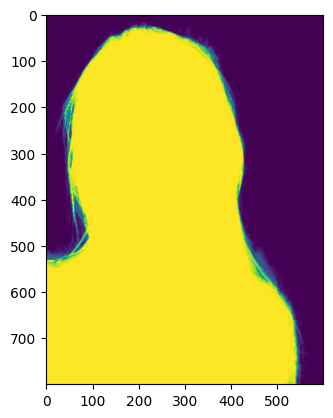

In [40]:
pil_img = Image.open(r'D:\\deskshop\\pystudy\\后续章节\\第13章\\hk\\training\\00004_matte.png')
base_dir = r'D:\\deskshop\\pystudy\\后续章节\\第13章\\hk\\training'
np_img = np.array(pil_img)
plt.imshow(np_img)
plt.show()

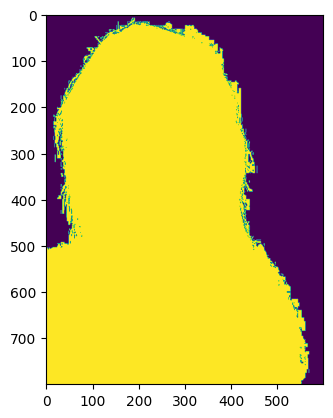

In [41]:
np_img[np_img >0] = 1
np_img
plt.imshow(np_img)

In [42]:
all_pics = glob.glob(r'D:\\deskshop\\pystudy\\后续章节\\第13章\\hk\\training\\*.png')
anno = [a for a in all_pics if 'matte' in a]
image = [a for a in all_pics if 'matte' not in a]
len(anno),len(image)

(1662, 1662)

In [43]:
index = np.random.permutation(len(image))
anno=np.array(anno)[index]
image=np.array(image)[index]

In [44]:
all_test_pics = glob.glob('D:\deskshop\pystudy\后续章节\第13章\hk\\testing\\*.png')
test_img = [a for a in all_test_pics if 'matte' not in a]
test_anno =  [a for a in all_test_pics if 'matte' in a]

In [45]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])

In [46]:
class hk_ds(data.Dataset):
    def __init__(self , img_path , anno_path):
        super().__init__()
        self.img = img_path
        self.anno = anno_path
        
    def __getitem__(self,index):
        
        img = self.img[index]
        anno = self.anno[index]
        
        pil_img = Image.open(img)
        img_tensor = transform(pil_img)
        
        
        pil_img = Image.open(anno)
        anno_tensor = transform(pil_img)        
        anno_tensor = torch.squeeze(anno_tensor).type(torch.long)
        anno_tensor[anno_tensor>0] = 1
        
        return img_tensor,anno_tensor
    
    def __len__(self):
        return len(self.img)
    
    
        
        
        

In [47]:
train_ds = hk_ds(image,anno)
test_ds = hk_ds(test_img,test_anno)
train_dl = data.DataLoader(train_ds,batch_size=8,shuffle=True)
test_dl = data.DataLoader(test_ds,batch_size=8)

In [48]:
l,p = next(iter(train_dl))

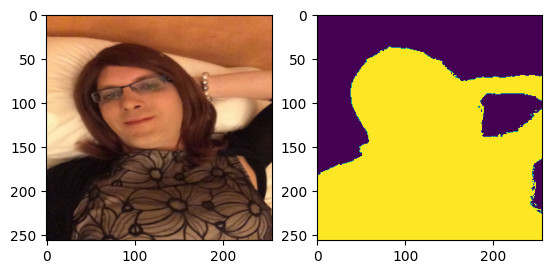

In [49]:
ll = l[1].permute(1,2,0)
pp = p[1]
plt.subplot(1,2,1)
plt.imshow(ll)
plt.subplot(1,2,2)
plt.imshow(pp)

In [50]:


# class Downsample(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.conv_relu = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, padding = 1),
#             nn.ReLU(),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding = 1),
#             nn.ReLU(),            
            
#         )
#         self.pool = nn.MaxPool2d(kernel_size=2)
        
#     def forward(self, x, is_pool = True):
        
#         if is_pool == True:
#             x = self.pool(x)
            
#         x = self.conv_relu(x)    
#         return x
        
class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Downsample, self).__init__()
        self.conv_relu = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, 
                                      kernel_size=3, padding=1),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(out_channels, out_channels, 
                                      kernel_size=3, padding=1),
                            nn.ReLU(inplace=True)
            )
        self.pool = nn.MaxPool2d(kernel_size=2)
    def forward(self, x, is_pool=True):
        if is_pool:
            x = self.pool(x)
        x = self.conv_relu(x)
        return x       
    
class Upsample(nn.Module):
    def __init__(self, channels):
        super(Upsample, self).__init__()
        self.conv_relu = nn.Sequential(
                            nn.Conv2d(2*channels, channels, 
                                      kernel_size=3, padding=1),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(channels, channels,  
                                      kernel_size=3, padding=1),
                            nn.ReLU(inplace=True)
            )
        self.upconv_relu = nn.Sequential(
                               nn.ConvTranspose2d(channels, 
                                                  channels//2, 
                                                  kernel_size=3,
                                                  stride=2,
                                                  padding=1,
                                                  output_padding=1),
                               nn.ReLU(inplace=True)
            )
        
    def forward(self, x):
        x = self.conv_relu(x)
        x = self.upconv_relu(x)
        return x


In [51]:
# class Upsample(nn.Module):
#     def __init__(self, channels):
#         super().__init__()
#         self.conv_relu = nn.Sequential(
#             nn.Conv2d(2*channels, channels, kernel_size=3, padding = 1),
#             nn.ReLU(),
#             nn.Conv2d(channels, channels, kernel_size=3, padding = 1),
#             nn.ReLU(),                 
#         )
#         self.upconv = nn.Sequential(
#             nn.ConvTranspose2d(channels, channels//2,kernel_size=3, padding=1,stride=2,output_padding=1)
#         )
#     def forward(self, x):
        
#         x = self.conv_relu(x)    
#         x = self.upconv(x)
#         return x    
  
        

In [52]:


class U_net(nn.Module):
    def __init__(self):
        super().__init__()
        self.down1 = Downsample(3,64)
        self.down2 = Downsample(64,128)
        self.down3= Downsample(128,256)
        self.down4 = Downsample(256,512)
        self.down5 = Downsample(512,1024)
        
        self.up = nn.Sequential(
            nn.ConvTranspose2d(1024,512,kernel_size=3,stride=2,padding=1,output_padding=1),
            nn.ReLU()                      
            
        )
        self.up1 = Upsample(512)
        self.up2 = Upsample(256)
        self.up3 = Upsample(128)
        
        self.conv_2 = Downsample(128,64)
        self.last = nn.Conv2d(64,2,kernel_size=1)
        
    def forward(self,x):
        x1 = self.down1(x,is_pool = False)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x5 = self.down5(x4)
        
        x5 = self.up(x5)
        
        x5 = torch.cat([x4,x5],dim=1)
        x5 = self.up1(x5)
        
        x5 = torch.cat([x3,x5],dim=1)
        x5 = self.up2(x5)
        
        x5 = torch.cat([x2,x5],dim=1)
        x5 = self.up3(x5)
        
        x5 = torch.cat([x1,x5],dim=1)
        
        x5 = self.conv_2(x5,is_pool = False)
        
        x5 = self.last(x5)
        
        return x5
            
        

In [53]:
model = U_net()
if torch.cuda.is_available():
    model.to('cuda')

In [54]:
model

U_net(
  (down1): Downsample(
    (conv_relu): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down2): Downsample(
    (conv_relu): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down3): Downsample(
    (conv_relu): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=T

In [55]:
from torch.optim import lr_scheduler
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(),lr=0.001)
exp_lr = lr_scheduler.StepLR(opt,5,0.5)


In [56]:
def fit(epoch, model, trainloader, testloader):
    correct = 0
    total = 0
    running_loss = 0
    
    model.train()
    for x, y in trainloader:
        if torch.cuda.is_available():
                x, y = x.to('cuda'), y.to('cuda')
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()
    exp_lr.step()
    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = correct / (total*256*256)
        
        
    test_correct = 0
    test_total = 0
    test_running_loss = 0 
    
    model.eval()
    with torch.no_grad():
        for x, y in testloader:
            if torch.cuda.is_available():
                x, y = x.to('cuda'), y.to('cuda')
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y).sum().item()
            test_total += y.size(0)
            test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader.dataset)
    epoch_test_acc = test_correct / (test_total*256*256)
    
        
    print('epoch: ', epoch, 
          'loss ', round(epoch_loss, 3),
          'accuracy:', round(epoch_acc, 3),
          'test_loss ', round(epoch_test_loss, 3),
          'test_accuracy:', round(epoch_test_acc, 3)
             )
        
    return epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc

In [57]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []
epochs=10
for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch,
                                                                 model,
                                                                 train_dl,
                                                                 test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch:  0 loss  0.072 accuracy: 0.714 test_loss  0.063 test_accuracy: 0.786
epoch:  1 loss  0.056 accuracy: 0.8 test_loss  0.047 test_accuracy: 0.84
epoch:  2 loss  0.046 accuracy: 0.842 test_loss  0.043 test_accuracy: 0.852
epoch:  3 loss  0.044 accuracy: 0.848 test_loss  0.043 test_accuracy: 0.852
epoch:  4 loss  0.044 accuracy: 0.849 test_loss  0.042 test_accuracy: 0.857
epoch:  5 loss  0.041 accuracy: 0.859 test_loss  0.04 test_accuracy: 0.864
epoch:  6 loss  0.039 accuracy: 0.867 test_loss  0.038 test_accuracy: 0.87
epoch:  7 loss  0.038 accuracy: 0.874 test_loss  0.039 test_accuracy: 0.868
epoch:  8 loss  0.036 accuracy: 0.88 test_loss  0.035 test_accuracy: 0.884
epoch:  9 loss  0.035 accuracy: 0.885 test_loss  0.036 test_accuracy: 0.88


In [58]:
PATH = r'D:\\deskshop\\pystudy\\unet_model.pth'


In [59]:
torch.save(model.state_dict(), PATH)

In [60]:
my_model = U_net()
my_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

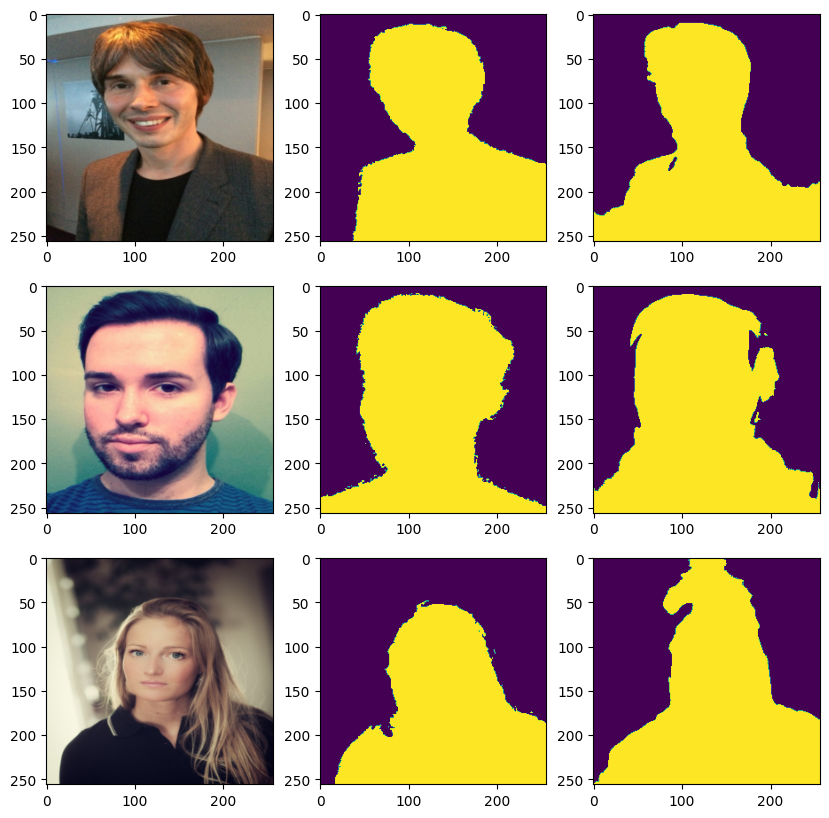

In [61]:
num=3

image, mask = next(iter(test_dl))
pred_mask = my_model(image)

plt.figure(figsize=(10, 10))
for i in range(num):
    plt.subplot(num, 3, i*num+1)
    plt.imshow(image[i].permute(1,2,0).cpu().numpy())
    plt.subplot(num, 3, i*num+2)
    plt.imshow(mask[i].cpu().numpy())
    plt.subplot(num, 3, i*num+3)
    plt.imshow(torch.argmax(pred_mask[i].permute(1,2,0), axis=-1).detach().numpy())

In [77]:
img = Image.open(r'D:/deskshop/pystudy/QQ截图20221029202245.jpg')
img1 = np.array(img)
img1.shape
img = transform(img)
img.size()

torch.Size([3, 256, 256])

In [78]:
img_batch = torch.unsqueeze(img , 0)
img_batch.size()

torch.Size([1, 3, 256, 256])

In [79]:
pre = my_model(img_batch)

In [80]:
pre[0].size()
result1 =torch.argmax( (pre[0].permute(1,2,0)),axis = -1)
result1.size()

torch.Size([256, 256])

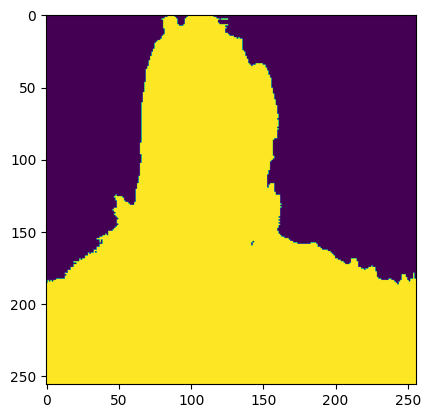

In [82]:
# result1 = result1.numpy()
plt.imshow(result1)